In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import linregress
import scipy.linalg
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

In [ ]:
class Model:

    def __init__(self, x_low, x_up, t_end, nx, nt, p0, s0, params, dim):

        if dim > 1 and x_low <= 0:
            raise Exception('Divide by 0 error will occur')

        self.x_low = x_low
        self.x_up = x_up
        self.t_end = t_end
        self.nx = nx
        self.nt = nt

        self.xs = np.linspace(x_low,x_up,self.nx+1)
        self.ts = np.linspace(0,t_end,self.nt)
        self.p0 = p0(self.xs[:-1])
        self.s0 = s0(self.xs[:-1])

        self.params = params
        self.dim = dim

        self.dt = self.ts[1]-self.ts[0]
        self.dx = self.xs[1]-self.xs[0]

        self.s00 = s0(x_low)

        if dim != 1:
            self.D1 = self.d1()
        self.D2 = self.d2()
        self.I = np.identity(self.nx)

    def simple_v(self, s0_j):
        V1 = np.zeros(self.nx)
        k = 1 + s0_j**self.params['m']
        V1[0] = (2 * self.dt) / (self.dx * k)
        return V1

    def complex_v(self, s0_j):
        V2 = np.zeros(self.nx)
        k = 1 + s0_j**self.params['m']
        V2[0] = - (self.dt / k)
        return V2

    def d1(self):
        D1 = np.zeros((self.nx, self.nx))
        D1[-1, -2] = -1 / self.xs[-1]
        D1[-1, -1] = 0

        for i in range(1, self.nx-1):
            D1[i, i-1] = -1 / self.xs[i]
            D1[i, i] = 0
            D1[i, i+1] = 1 / self.xs[i]

        return D1

    def d2(self):
        D2 = np.zeros((self.nx, self.nx))
        D2[0, 0] = -2
        D2[0, 1] = 2
        D2[-1, -2] = 1
        D2[-1, -1] = -2

        for i in range(1, self.nx-1):
            D2[i, i-1] = 1
            D2[i, i] = -2
            D2[i, i+1] = 1

        return D2

    def fdm(self):
        p_next = np.copy(self.p0)
        s_next = np.copy(self.s0)

        p = [] # save all steps of p here
        s = [] # save all steps of p here
        havg = 0

        back_steps = int(self.params['tau_bar']/self.dt)

        for j in range(self.nt):
            p.append(p_next)
            s.append(s_next)
            delay = j - back_steps
            if delay >= 0:
                s0_j = s[delay][0]
            else:
                s0_j = self.s00

            havg += self.dt * (1 - (1 / (1 + (s0_j)**self.params['m'])))

            if dim == 1:
                V1 = self.simple_v(s0_j)

                A = (self.I - self.dt * (self.D2 / (self.dx ** 2) - self.params['gamma'] * np.diag(s[-1]) - \
                                         (1 + self.params['sigma']) * self.I))

                p_next = scipy.linalg.solve(A, (p[-1] + V1))

                B = (self.I - self.dt * (self.params['delta']*(self.D2 / (self.dx ** 2)) + \
                                         (self.params['eta'] * self.params['gamma']) * np.diag(p[-1]) - \
                                         self.params['beta'] * self.I))

                s_next = scipy.linalg.solve(B, ((self.dt * self.params['eta'] * self.params['sigma']) * p[-1] + s[-1]))
            else:
                V1 = self.simple_v(s0_j)
                V2 = self.complex_v(s0_j)

                A = (self.I - self.dt * (self.D2 / (self.dx ** 2) + ((self.dim - 1) / (2 * self.dx)) * self.D1 - \
                                         self.params['gamma'] * np.diag(s[-1]) - (1 + self.params['sigma']) * self.I))

                p_next = scipy.linalg.solve(A, (p[-1] + V1 + (self.dim - 1) * (V2/self.x_low)))

                B = (self.I - self.dt * (self.params['delta'] * (self.D2 / (self.dx ** 2)) + \
                                         ((self.params['delta'] * (self.dim - 1)) / (2 * self.dx)) * self.D1 + \
                                         (self.params['eta'] * self.params['gamma']) * np.diag(p[-1]) - \
                                         self.params['beta'] * self.I))

                s_next = scipy.linalg.solve(B, ((self.dt * self.params['eta'] * self.params['sigma']) * p[-1] + s[-1]))

        havg /= t_end

        return p, s, havg

In [ ]:
def plot_3d(q1, q2, havg, x_low, x_up, nx, nt, t_end, name1, name2):
    num_timesteps = len(q1)
    T = np.linspace(0, t_end, num_timesteps)
    X = np.linspace(x_low, x_up, nx)
    X, T = np.meshgrid(X, T)

    q1_array = np.array(q1)
    q2_array = np.array(q2)

    x_slice_index = 0
    t_slice = T[:, x_slice_index]
    p_slice = q1_array[:, x_slice_index]
    s_slice = q2_array[:, x_slice_index]

    plt.figure(figsize=(8, 6))
    plt.plot(t_slice[::8], p_slice[::8], label=name1, color='blue', linewidth=8)
    plt.plot(t_slice[::8], s_slice[::8], label=name2, color='red', linestyle="dashed", linewidth=8)

    plt.xticks([0, t_end/2, t_slice[-1]], fontsize=35)
    rounded_min = round(np.min([np.min(p_slice), np.min(s_slice)]), 1)
    rounded_max = round(np.max([np.max(p_slice), np.max(s_slice)]), 1)
    plt.yticks([rounded_min, rounded_max], fontsize=35)

    plt.grid(True)

    # Adding the value of havg as a text annotation within the graph
    havg_text = r'$h_\mathrm{avg} = $' + str(round(havg, 3))
    plt.text(0.5, 0.9, havg_text, fontsize=35, color='black', ha='center', transform=plt.gca().transAxes, alpha = 0.5)

    plt.savefig('pe_se_slice.png')
    plt.show()

def new_3dp(q, x_low, x_up, nx, nt, t_end, name):
    num_timesteps = len(q)
    T = np.linspace(0, t_end, num_timesteps)
    X = np.linspace(x_low, x_up, nx)
    X, T = np.meshgrid(X, T)

    q_array = np.array(q)

    fig = plt.figure(figsize=(10, 8))  # Adjust the figure size here
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, q_array, cmap='viridis', alpha=0.8)

    ax.set_xlabel('r', fontsize=30, labelpad=20)
    ax.set_ylabel('t', fontsize=30, labelpad=20)
#     ax.set_zlabel('values', fontsize=30, labelpad=20)

    plt.xticks([x_low, x_up], fontsize=30)
    plt.yticks([0, t_end], fontsize=30)

    rounded_min = round(np.min(q), 1)
    rounded_max = round(np.max(q), 1)
    ax.set_zticks([rounded_min, rounded_max])

    ax.tick_params(axis='z', labelsize=30)

    plt.tight_layout()  # Adjust the layout to eliminate excess whitespace

    plt.savefig('simp', bbox_inches='tight')  # Use bbox_inches='tight' to avoid cropping
    plt.show()

def new_3ds(q, x_low, x_up, nx, nt, t_end, name):
    num_timesteps = len(q)
    T = np.linspace(0, t_end, num_timesteps)
    X = np.linspace(x_low, x_up, nx)
    X, T = np.meshgrid(X, T)

    q_array = np.array(q)

    fig = plt.figure(figsize=(14, 10))  # Increase the figure size here
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, q_array, cmap='viridis', alpha=0.8)

    ax.set_xlabel('r', fontsize=25, labelpad=20)
    ax.set_ylabel('t', fontsize=25, labelpad=20)
    ax.set_zlabel('values', fontsize=25, labelpad=20)

    plt.xticks([x_low, x_up], fontsize=25)
    plt.yticks([0, t_end], fontsize=25)

    rounded_min = round(np.min(q), 1)
    rounded_max = round(np.max(q), 1)
    ax.set_zticks([rounded_min, rounded_max])

    ax.tick_params(axis='z', labelsize=25)

    plt.tight_layout()  # Adjust the layout to eliminate excess whitespace

    plt.savefig('sims', bbox_inches='tight')  # Use bbox_inches='tight' to avoid cropping
    plt.show()



params = {
    'm': 10,
    'gamma': 5,
    'sigma': 0.01,
    'delta': 0.15,
    'eta': 2,
    'beta': 0.15,
    'tau_bar': 4,
}

t_end = 50
nx = 512
nt = 512
dim = 3

# n=1, use this:
C1_1d = 1.5643
C2_1d = 0.6394
omega_1d = 0.4
norm_1d = 0.5
rstar_1d = 2.5

xlow_1d = 0
xup_1d = 5

p01d = lambda x: C1_1d*np.exp(-C2_1d*(x-xlow_1d)-(x-xlow_1d)**2)
s01d = lambda x: 1/omega_1d*norm_1d*(np.cosh((x-rstar_1d)/omega_1d))**(-2)

# n=2, use this:
C1_2d = 0.1507
C2_2d = -2.3411
omega_2d = 0.4
norm_2d = 0.5
rstar_2d = 2.75

xlow_2d = 0.25
xup_2d = 5.25

p02d = lambda x: C1_2d*np.exp(-C2_2d*(x-xlow_2d)-(x-xlow_2d)**2)*1/x
s02d = lambda x: 1/omega_2d*norm_2d*(np.cosh((x-rstar_2d)/omega_2d))**(-2)*1/x

# n=3, use this:
C1_3d = 0.01493
C2_3d = -3.8135
omega_3d = 0.4
norm_3d = 0.5
rstar_3d = 2.75

xlow_3d = 0.25
xup_3d = 5.25

p03d = lambda x: C1_3d*np.exp(-C2_3d*(x-xlow_3d)-(x-xlow_3d)**2)*1/x**2
s03d = lambda x: 1/omega_3d*norm_3d*(np.cosh((x-rstar_3d)/omega_3d))**(-2)*1/x**2

one_dim = Model(xlow_3d, xup_3d, t_end, nx, nt, p03d, s03d, params, dim)
pe, se, havg = one_dim.fdm()

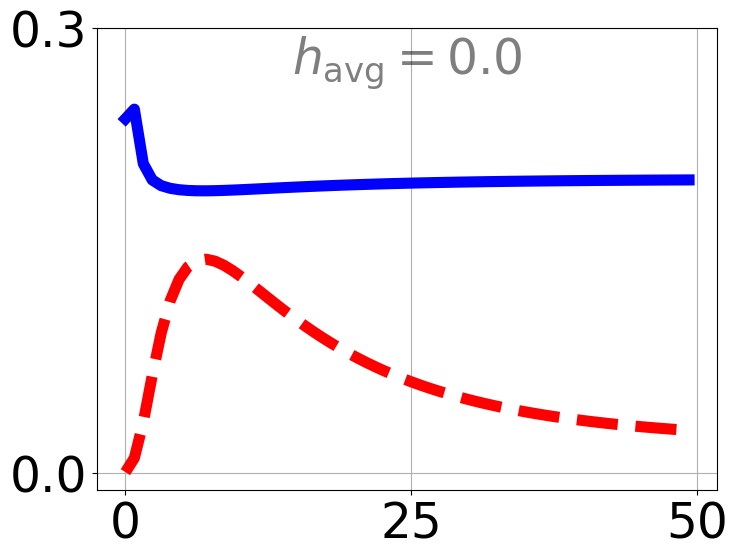

<ipython-input-5-78c65c880880>:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout to eliminate excess whitespace


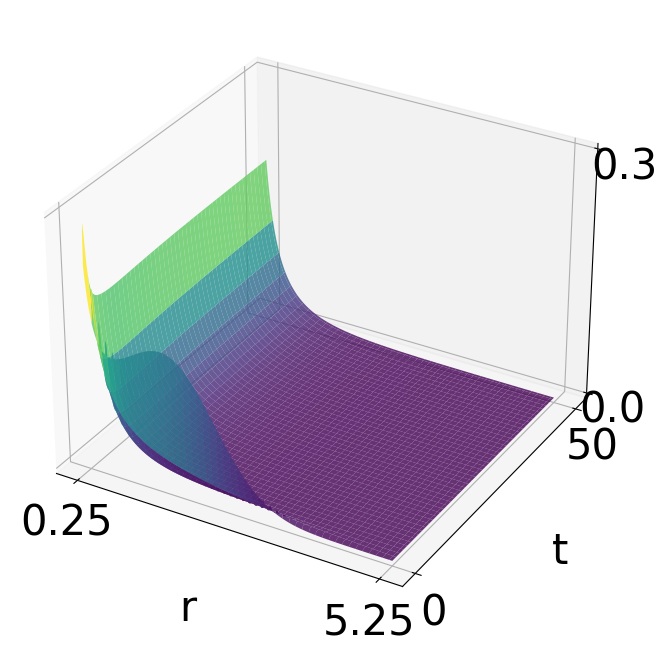

<ipython-input-5-78c65c880880>:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()  # Adjust the layout to eliminate excess whitespace


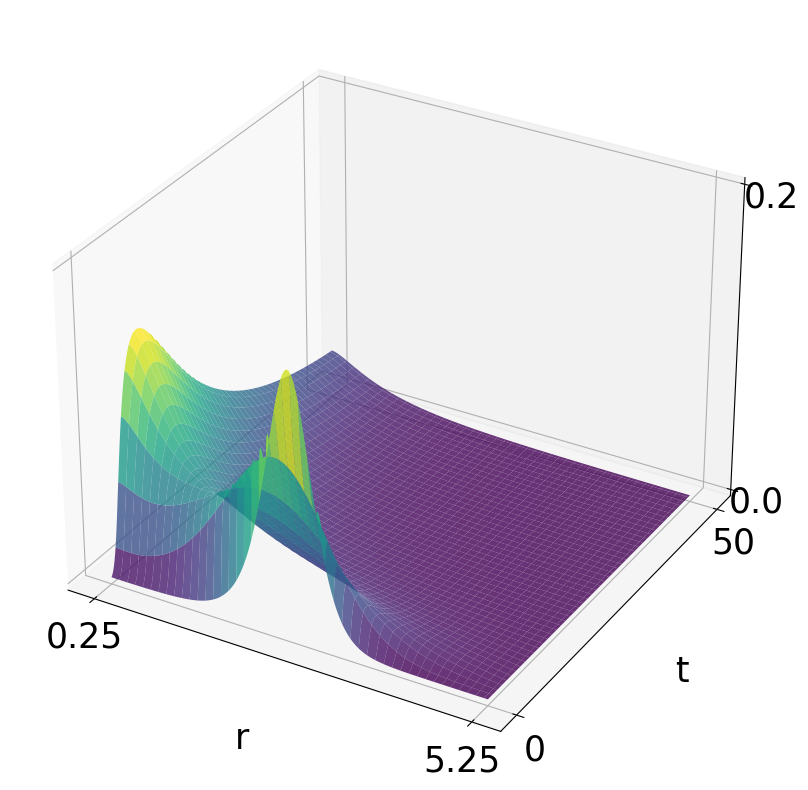

In [ ]:
plot_3d(pe, se, havg, xlow_3d, xup_3d, nx, nt, t_end, "PrPc", "PrPSc")
new_3dp(pe, xlow_3d, xup_3d, nx, nt, t_end, "PrPc")
new_3ds(se, xlow_3d, xup_3d, nx, nt, t_end, "PrPSc")